So far, we've explored a few different ways we can work with medium-sized data sets in pandas. First, we learned how to reduce a dataframe's memory footprint by selecting the optimal data types for each column. Then, we discussed how to work with dataframe chunks and modify our processing logic. In this file, we'll explore how to augment pandas with SQLite.

While pandas stores and works with data in memory, a database tool like SQLite can represent data on disk. This means that while pandas is limited by the amount of available memory (usually a few gigabytes), **SQLite is limited only by the amount of available disk space** (usually hundreds of gigabytes to a few terabytes). This difference is even more pronounced when working with servers in the cloud because the price for extra disk storage is much cheaper than extra memory. With a [maximum supported file size limit](https://www.sqlite.org/limits.html) of 140 terabytes, we can store large data sets in a SQLite database, write SQL queries to extract a subset of the data we want to work with, and use pandas to explore, analyze, and visualize the subset.

We'll continue to work with the data set on MOMA Exhibitions. First, we'll create a new SQLite database file and load the entire data set into a single SQLite table. Let's work **under the constraint that we have very limited memory**, and that we need to read the data set into chunks and append them to a table in SQLite.

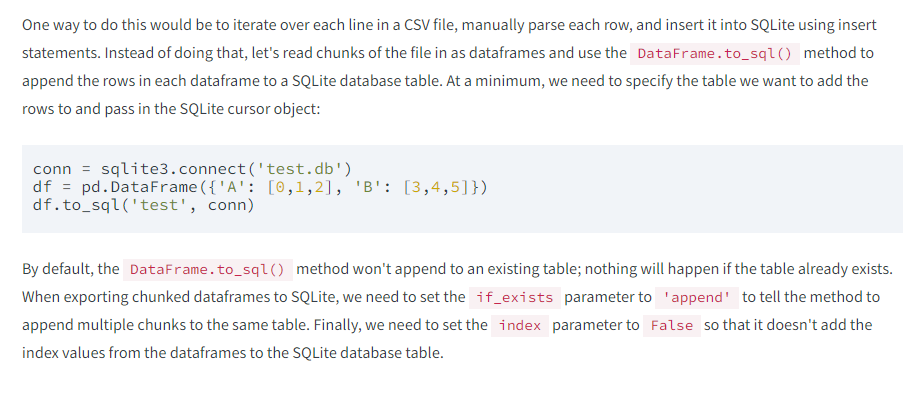

**Task**

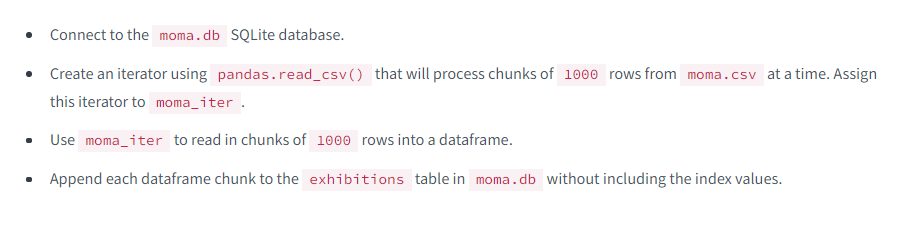

**Answer**

In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect('moma.db')

moma_iter = pd.read_csv('moma.csv', chunksize=1000)

for chunk in moma_iter:
    chunk.to_sql("exhibitions", conn, if_exists='append', index=False)

When we use the `DataFrame.to_sql()` method to add rows to a SQLite database, pandas automatically converts the dataframe's data types to the equivalent SQLite data types. We can find a list of the SQLite data types in the [documentation](https://www.sqlite.org/datatype3.html), which we've recreated below. We'll notice that SQLite doesn't have special data types for representing datetime, boolean, or categorical values.

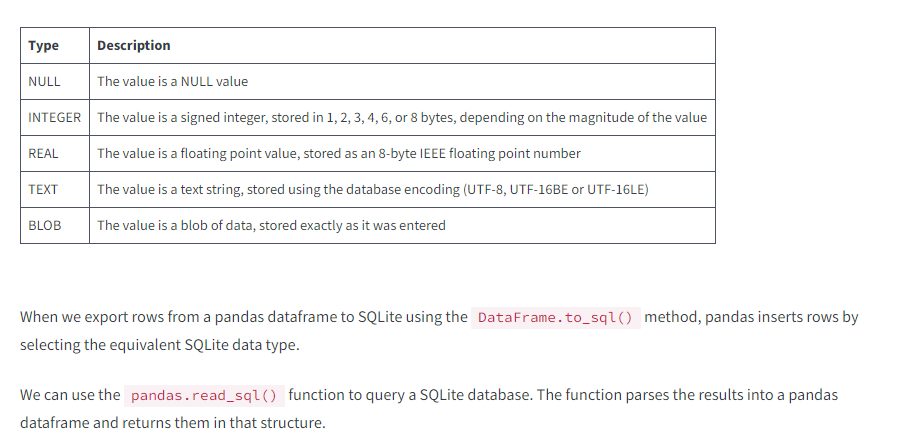

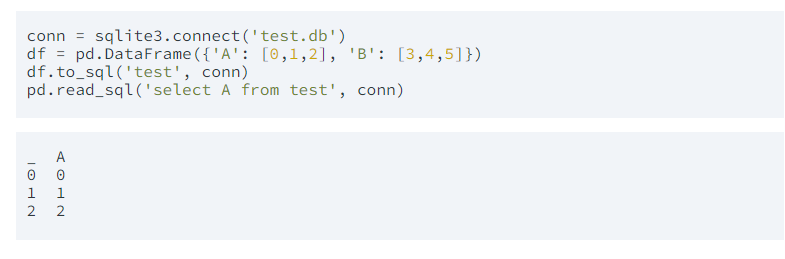

**Task**

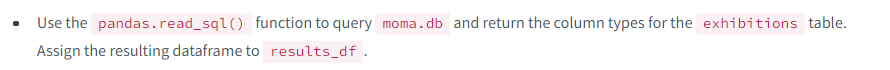

**Answer**

In [3]:
results_df = pd.read_sql('PRAGMA table_info(exhibitions);', conn)
results_df

,cid,name,type,notnull,dflt_value,pk
0,0,ExhibitionID,INTEGER,0,None,0
1,1,ExhibitionNumber,TEXT,0,None,0
2,2,ExhibitionTitle,TEXT,0,None,0
3,3,ExhibitionCitationDate,TEXT,0,None,0
4,4,ExhibitionBeginDate,TEXT,0,None,0
5,5,ExhibitionEndDate,TEXT,0,None,0
6,6,ExhibitionSortOrder,INTEGER,0,None,0
7,7,ExhibitionURL,TEXT,0,None,0
8,8,ExhibitionRole,TEXT,0,None,0
9,9,ConstituentID,REAL,0,None,0


The SQLite database consumes 11.1 megabytes on disk, which closely matches the amount of disk space the original CSV file consumes. Let's see if we can reduce the amount of disk space the SQLite database requires by optimizing the data types of the columns in the `exhibitions` table.

If we'll recall from the first file, we had to clean the data a bit to be able to convert some of the text columns to a numeric type. Unfortunately, data cleaning in SQLite can be cumbersome for many tasks. Because we're reading in values to pandas first anyway, let's focus our type optimization efforts there. Selecting the correct types in SQLite reduces the disk footprint of the database file, and can make some SQLite operations faster.

**Task**

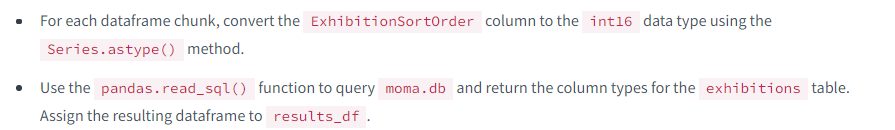

**Answer**

In [4]:
moma_iter = pd.read_csv('moma.csv', chunksize=1000)

for chunk in moma_iter:
    chunk['ExhibitionSortOrder'] = chunk['ExhibitionSortOrder'].astype('int16')
    chunk.to_sql("exhibitions", conn, if_exists='append', index=False)
    
results_df = pd.read_sql('PRAGMA table_info(exhibitions);', conn)
results_df

,cid,name,type,notnull,dflt_value,pk
0,0,ExhibitionID,INTEGER,0,None,0
1,1,ExhibitionNumber,TEXT,0,None,0
2,2,ExhibitionTitle,TEXT,0,None,0
3,3,ExhibitionCitationDate,TEXT,0,None,0
4,4,ExhibitionBeginDate,TEXT,0,None,0
5,5,ExhibitionEndDate,TEXT,0,None,0
6,6,ExhibitionSortOrder,INTEGER,0,None,0
7,7,ExhibitionURL,TEXT,0,None,0
8,8,ExhibitionRole,TEXT,0,None,0
9,9,ConstituentID,REAL,0,None,0


Generating a pandas dataframe from our results set unlocks a few different workflows for us. One involves doing most of the computation in SQL, then parsing the results as a dataframe. Another workflow involves doing the data selection with SQL, but the iterative exploration and analysis in pandas. Each workflow has its own set of trade-offs, which we'll explore in greater depth. We'll start by performing all of the processing in SQL itself.

**Task**

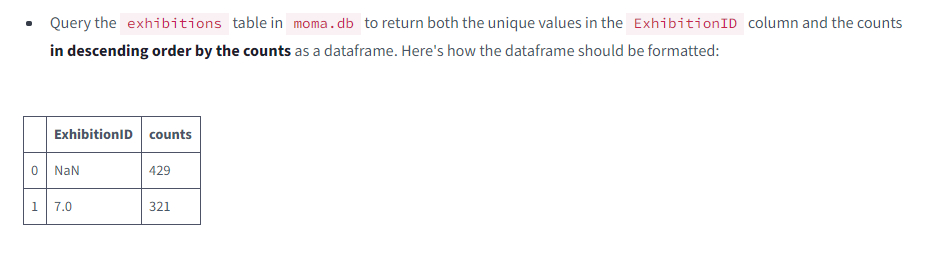

**Answer**

In [5]:
q = 'select exhibitionid, count(*) as counts from exhibitions group by exhibitionid order by counts desc;'
eid_counts = pd.read_sql(q, conn)
eid_counts[:10]

,ExhibitionID,counts
0,NaN,858
1,7.0,642
2,3838.0,604
3,3030.0,568
4,3988.0,550
5,2600.0,524
6,79.0,518
7,10601.0,512
8,3939.0,508
9,3036.0,488


In the last step, we expressed the entire computation in SQL. Because this was a small task, the results came back relatively quickly. SQLite will take much longer for larger computations because it's not operating in memory. We can treat SQLite primarily as an archival data store instead, and only use SQL to return subsets of the data. If we restrict the size of the subsets and ensure the results can fit into memory as a dataframe, we can move all of our heavier computations to pandas.

Pandas has several advantages over SQLite. First, pandas has a large suite of functions and methods for performing common operations. It also has a diverse type system we can use to save space and improve code running speed. Finally, pandas works in memory and will be much quicker for most tasks.

Let's rewrite the task we performed in the last step using a mix of pandas and SQLite.

**Task**

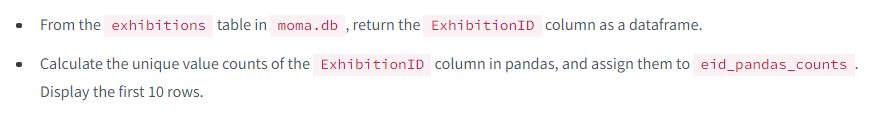

**Answer**

In [7]:
q = 'select exhibitionid from exhibitions;'
eid_df = pd.read_sql(q, conn)

eid_pandas_counts = eid_df['ExhibitionID'].value_counts()
eid_pandas_counts[:10]

7.0       642
3838.0    604
3030.0    568
3988.0    550
2600.0    524
         ... 
4164.0      6
2863.0      6
4249.0      6
2896.0      6
10.0        6
Name: ExhibitionID, Length: 921, dtype: int64

The techniques we've learned so far are useful whenever the dataframe representing the results of a SQL query fits in memory. When we're working with a data set that consumes multiple terabytes on disk as a SQLite database file, we may find ourselves wanting to explore a subset of the data in pandas, but lacking sufficient memory to read the subset in as a dataframe. In cases like these, we can read the results in as dataframe chunks and then batch process the chunks.

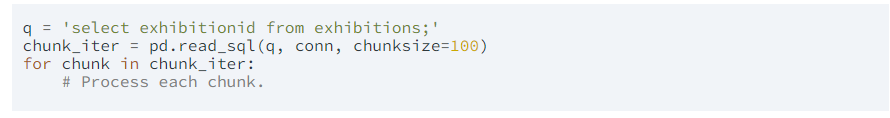

We'll often find ourself working on a data science team that has databases containing millions of rows. While we can perform most of the computation in SQL itself, pandas (and the Python ecosystem more generally) has richer support for mathematical operations and data visualization. Querying the data in SQL and working with batches of the results set will help us make the most of SQL and pandas.

In this file, we explored how to augment our pandas workflow with SQLite to handle larger data sets. We learned that while SQLite can represent larger data sets on disk, it's slower for most computations. 